In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from scipy import stats

In [2]:
class ThompsonSamplingBase:
    def __init__(self, contents_ctr):
        """
        contents_ctr : [[0.1, 0.3, 0.3,0.1, ],[0.55, 0.9, 0.7],[0.8, 0.3, 0.4, 0.1]]
        """
        self.length = sum(len(ctr) for ctr in contents_ctr)
        self.gt = np.concatenate(contents_ctr)
        self.split(contents_ctr)

    def split(self, contents_ctr):
        contents_ctr = [np.array(c) for c in contents_ctr]
        self.contents_ctr = contents_ctr[0]
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cans_ctr = contents_ctr[1:]

    def initalize(self):
        self.candidates = [*range(len(self.contents_ctr))]
        self.time_decays = {i:1 for i in range(self.length)}
        self.cluster_idx = [len(self.contents_ctr)]
        self.selected = [0]*len(self.candidates)

    def normalize(self, ctr):
        return ctr / sum(ctr)

    def cluster_decay(self):
        pass

    def time_decay(self):
        for i in range(len(self.contents_ctr)):
            self.time_decays[i] += 1

    def updated_arms(self, i):
        pass

    def add_new_cluster(self):
        pass

    def run(self, iteration = 100):
        self.initalize()

        grid_size = 3
        x = 0
        ploted = 0
        fig, ax = plt.subplots(grid_size, grid_size, figsize = (8,6))
        sec = int(iteration/grid_size)
        circle = cycle(range(grid_size))

        for i in range(iteration):

            self.updated_arms(i)

            if i % (sec//grid_size) == 0:
                y = next(circle)
                ax[x,y].bar(self.candidates, self.selected)

                if x == 0:
                    ax[x,y].set_title(f"{i}'th iter")
                else:
                    ax[x,y].set_title(f"{x+1}'th cans added {i}'th iter")

                ploted += 1
                if ploted * (x+1) == grid_size**2:
                    break
                if ploted == grid_size:
                    x += 1
                    ploted = 0
                    self.add_new_cluster()

        print(self.norm_contents_ctr)
        selected = np.array(self.selected)
        print(selected/sum(selected))
        plt.show()

### Dirichlet TS

In [3]:
class DirichletThompsonSampling(ThompsonSamplingBase):
    def __init__(self, contents_ctr):
        super().__init__(contents_ctr)
        self.prior = np.ones_like(self.contents_ctr)

    def cluster_decay(self, updated_prior):
        curr_cluster = 0
        cluster_decay_factor= pow(10., len(self.cluster_idx))

        for item in range(len(updated_prior)):

            if item >= self.cluster_idx[curr_cluster]:
                cluster_decay_factor /= 10.
                curr_cluster += 1

            updated_prior[item] /= self.time_decays[item] * cluster_decay_factor

    def draw(self, prior):
        recommend = np.random.dirichlet(prior, 1)
        res = recommend[0].argsort()[::-1]

        return res

    def updated_arms(self, iteration, topk = 3):
        updated_prior = np.copy(self.prior)

        self.cluster_decay(updated_prior)

        res = self.draw(updated_prior)
        for k in range(topk):
            self.selected[res[k]] += 1

        click = np.random.choice(self.candidates, p = self.norm_contents_ctr)
        self.prior[click] += 1

        self.time_decay()

        if iteration%10000 == 0:
            print('topk : ', res)

    def add_new_cluster(self):
        candidates = self.cans_ctr.pop(0)
        self.contents_ctr = np.concatenate([self.contents_ctr, candidates])
        self.selected = np.concatenate([self.selected, np.zeros_like(candidates)])
        self.candidates = list(range(len(self.contents_ctr)))
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cluster_idx.append(len(self.contents_ctr))

        self.prior = np.concatenate([self.prior, np.ones_like(candidates)])

### Beta TS

In [4]:
class BetaThompsonSampling(ThompsonSamplingBase):
    def __init__(self, contents_ctr):
        super().__init__(contents_ctr)
        self.alpha, self.beta = np.ones_like(self.contents_ctr), np.ones_like(self.contents_ctr)

    def cluster_decay(self, updated_alpha, updated_beta):
        curr_cluster = 0
        cluster_decay_factor = pow(10., len(self.cluster_idx))

        for item in range(len(updated_alpha)):

            if item >= self.cluster_idx[curr_cluster]:
                cluster_decay_factor /= 10.
                curr_cluster += 1

            updated_alpha[item] /= self.time_decays[item] * cluster_decay_factor
            updated_beta[item] /= self.time_decays[item] * cluster_decay_factor

    def draw(self, alpha, beta):
        score = []
        for a, b in zip(alpha, beta):
            reward = np.random.beta(a, b)
            score.append(reward)

        return np.array(score).argsort()[::-1]

    def updated_arms(self, iteration, topk=3):
        updated_alpha = np.copy(self.alpha)
        updated_beta = np.copy(self.beta)
        self.cluster_decay(updated_alpha, updated_beta)

        res = self.draw(updated_alpha, updated_beta)
        click = np.random.choice(self.candidates, p=self.norm_contents_ctr)

        for item in res[:topk]:
            self.selected[item] += 1

            if item == click:
                self.alpha[item] += 1
            else:
                self.beta[item] += 1

        self.time_decay()
        
        if iteration%10000 == 0:
            print('topk : ', res)
            
#             x = np.linspace(0, 1, 1002)[1:-1]
#             plt.figure(figsize=(10,5))

#             for i,(a,b) in enumerate(zip(self.alpha, self.beta)):
#                 dist = stats.beta(a,b)
#                 dist_y = dist.pdf(x)
#                 plt.plot(x,dist_y,label = f'{i}th : ( {a} , {b} ) / E : {a/(a+b):.3f} / R : {self.norm_contents_ctr[i]:.3f}')

#             plt.legend()
#             plt.show()

    def add_new_cluster(self):
        candidates = self.cans_ctr.pop(0)
        self.contents_ctr = np.concatenate([self.contents_ctr, candidates])
        self.selected = np.concatenate([self.selected, np.zeros_like(candidates)])
        self.candidates = list(range(len(self.contents_ctr)))
        self.norm_contents_ctr = self.normalize(self.contents_ctr)
        self.cluster_idx.append(len(self.contents_ctr))

        self.alpha = np.concatenate([self.alpha, np.ones_like(candidates)])
        self.beta = np.concatenate([self.beta, np.ones_like(candidates)])

### (1)

In [5]:
contents_ctr =[[0.1, 0.3, 0.3,0.1,],
               [0.55, 0.9, 0.7],
               [0.8, 0.3, 0.4, 0.1]]

<BarContainer object of 11 artists>

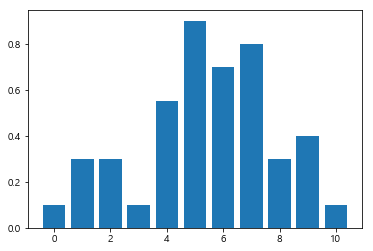

In [6]:
plt.bar(list(range(11)), np.concatenate(contents_ctr))

topk :  [1 0 3 2]
topk :  [1 2 0 3]
topk :  [2 0 3 1]
topk :  [5 4 6 0 1 2 3]
topk :  [5 6 1 4 2 3 0]
topk :  [2 6 5 1 4 0 3]
topk :  [ 9  8  2  7  5  6 10  4  0  3  1]
topk :  [ 8  7  5  9 10  6  4  3  2  1  0]
topk :  [ 4  9  8  5  7  6 10  3  2  1  0]
[0.02197802 0.06593407 0.06593407 0.02197802 0.12087912 0.1978022
 0.15384615 0.17582418 0.06593407 0.08791209 0.02197802]
[0.05648243 0.09936363 0.09888738 0.05507618 0.12069735 0.14656107
 0.13499233 0.10925986 0.06636742 0.08317115 0.02914121]


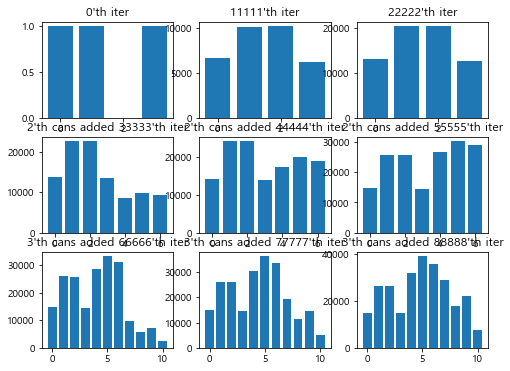

In [7]:
dts = DirichletThompsonSampling(contents_ctr)
dts.run(100000)

topk :  [2 0 1 3]
topk :  [2 1 3 0]
topk :  [2 0 3 1]
topk :  [2 5 6 4 1 3 0]
topk :  [3 0 6 2 5 1 4]
topk :  [3 1 2 4 5 6 0]
topk :  [ 4  1  7  8  6  9 10  5  3  2  0]
topk :  [ 4  2  1  9  7  5 10  8  6  3  0]
topk :  [ 9  7  5  6 10  8  4  3  2  1  0]
[0.02197802 0.06593407 0.06593407 0.02197802 0.12087912 0.1978022
 0.15384615 0.17582418 0.06593407 0.08791209 0.02197802]
[0.0769649  0.15898105 0.16090855 0.07144866 0.09868863 0.14854856
 0.1217736  0.08594614 0.03175496 0.04078495 0.00419999]


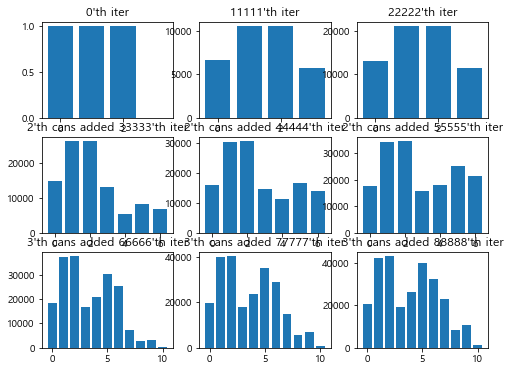

In [8]:
bts = BetaThompsonSampling(contents_ctr)
bts.run(100000)

### 2

In [9]:
contents_ctr =[[0.9, 0.3, 0.8,0.1,],
                [0.55, 0.2, 0.7],
                [0.8, 0.3, 0.4, 0.9]]

<BarContainer object of 11 artists>

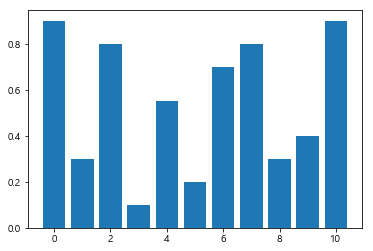

In [10]:
plt.bar(list(range(11)), np.concatenate(contents_ctr))

topk :  [0 1 2 3]
topk :  [0 1 2 3]
topk :  [1 0 2 3]
topk :  [6 4 0 2 5 3 1]
topk :  [6 4 0 2 5 3 1]
topk :  [6 1 4 5 0 3 2]
topk :  [ 7  9 10  8  6  5  4  3  2  1  0]
topk :  [10  7  8  6  4  9  5  3  2  1  0]
topk :  [ 7 10  9  8  6  5  2  4  3  1  0]
[0.1512605  0.05042017 0.13445378 0.01680672 0.09243697 0.03361345
 0.11764706 0.13445378 0.05042017 0.06722689 0.1512605 ]
[0.12498734 0.08136365 0.11984985 0.02962496 0.12022485 0.06877116
 0.13082234 0.09882738 0.05430368 0.06785242 0.10337237]


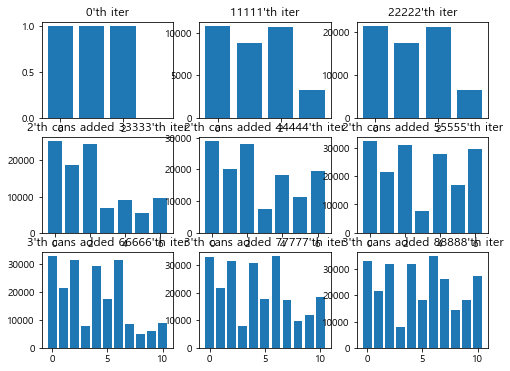

In [11]:
dts = DirichletThompsonSampling(contents_ctr)
dts.run(100000)

topk :  [0 2 3 1]
topk :  [2 0 1 3]
topk :  [2 0 1 3]
topk :  [2 6 4 0 5 3 1]
topk :  [5 2 6 4 3 1 0]
topk :  [4 6 1 3 5 2 0]
topk :  [ 5  1 10  6  9  7  0  8  4  3  2]
topk :  [ 2  7  9  5 10  0  8  6  4  3  1]
topk :  [ 6 10  9  7  8  5  4  3  2  1  0]
[0.1512605  0.05042017 0.13445378 0.01680672 0.09243697 0.03361345
 0.11764706 0.13445378 0.05042017 0.06722689 0.1512605 ]
[0.19557726 0.1200636  0.18862476 0.01742623 0.11455486 0.02543247
 0.13473358 0.06935991 0.01199624 0.0373087  0.08492239]


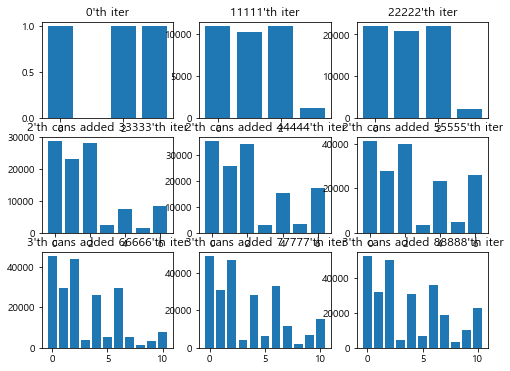

In [12]:
bts = BetaThompsonSampling(contents_ctr)
bts.run(100000)

### 3

In [13]:
contents_ctr =[[0.3, 0.2, 0.5,0.1,],
                [0.3, 0.2, 0.5],
                [0.8, 0.7, 0.8, 0.9]]

<BarContainer object of 11 artists>

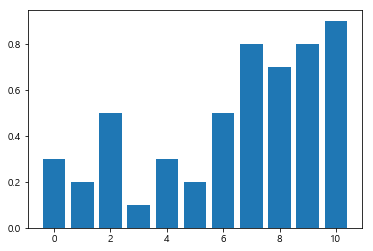

In [14]:
plt.bar(list(range(11)), np.concatenate(contents_ctr))

topk :  [0 1 2 3]
topk :  [2 0 3 1]
topk :  [2 0 1 3]
topk :  [5 4 2 6 3 1 0]
topk :  [6 5 4 1 2 3 0]
topk :  [0 5 6 4 3 2 1]
topk :  [10  7  6  4  9  8  5  3  2  1  0]
topk :  [ 8  9  7 10  0  6  5  4  3  2  1]
topk :  [ 7  8  9 10  6  4  5  3  2  1  0]
[0.05660377 0.03773585 0.09433962 0.01886792 0.05660377 0.03773585
 0.09433962 0.1509434  0.13207547 0.1509434  0.16981132]
[0.09618738 0.07873115 0.1171686  0.04559994 0.10572362 0.08884489
 0.12804359 0.08614114 0.0783299  0.08527489 0.08995489]


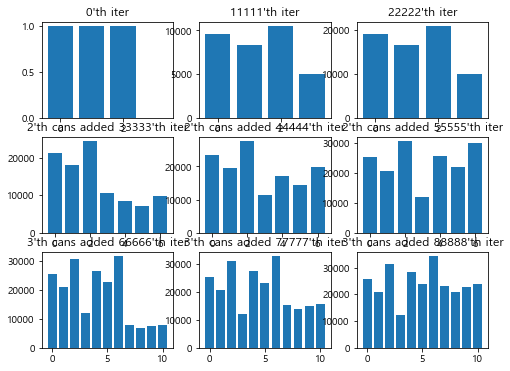

In [15]:
dts = DirichletThompsonSampling(contents_ctr)
dts.run(100000)

topk :  [3 2 1 0]
topk :  [0 2 1 3]
topk :  [0 2 1 3]
topk :  [6 2 4 5 3 1 0]
topk :  [2 6 0 4 1 5 3]
topk :  [0 6 4 1 5 3 2]
topk :  [ 6  9  7  8 10  5  4  3  2  1  0]
topk :  [ 4  6  7  9 10  8  5  3  2  1  0]
topk :  [ 1 10  9  8  7  6  5  4  3  2  0]
[0.05660377 0.03773585 0.09433962 0.01886792 0.05660377 0.03773585
 0.09433962 0.1509434  0.13207547 0.1509434  0.16981132]
[0.14861231 0.12224235 0.19565601 0.03944995 0.09410238 0.04661244
 0.13999858 0.05490743 0.04615119 0.05431868 0.05794868]


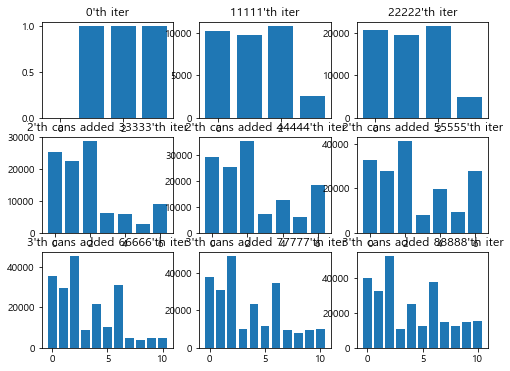

In [16]:
bts = BetaThompsonSampling(contents_ctr)
bts.run(100000)

In [17]:
def beta_dist(bts):

    x = np.linspace(0, 1, 1002)[1:-1]
    plt.figure(figsize=(10,5))

    for i,(a,b) in enumerate(zip(bts.alpha, bts.beta)):
        dist = stats.beta(a,b)
        dist_y = dist.pdf(x)
        plt.plot(x,dist_y,label = f'{i}th : ( {a} , {b} ) / E : {a/(a+b):.3f} / R : {bts.norm_contents_ctr[i]:.3f}')

    plt.legend()
    plt.show()

# beta_dist(bts)

In [19]:
# updated_alpha, updated_beta = np.copy(bts.alpha), np.copy(bts.beta)

# curr_cluster = 0
# cluster_decay_factor = pow(10., len(bts.cluster_idx))

# for item in range(len(updated_alpha)):

#     if item >= bts.cluster_idx[curr_cluster]:
#         cluster_decay_factor /= 10.
#         curr_cluster += 1

#     updated_alpha[item] /= bts.time_decays[item] * cluster_decay_factor
#     updated_beta[item] /= bts.time_decays[item] * cluster_decay_factor
    
# x = np.linspace(0, 1, 1002)[1:-1]
# plt.figure(figsize=(10,5))

# for i,(a,b) in enumerate(zip(updated_alpha, updated_beta)):
#     dist = stats.beta(a,b)
#     dist_y = dist.pdf(x)
#     plt.plot(x,dist_y,label = f'{i}th : ( {a} , {b} ) / E : {a/(a+b):.3f} / R : {bts.norm_contents_ctr[i]:.3f}')

# plt.legend()
# plt.show()